## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(path):
    """
    Load train, test, and validation datasets
    Parameters:
        path: a directory to store dataset
    Return:
        dog_files: an array that contains file paths of all dog files
        dog_targets: an array that contains one-hot encode labels of all dog files.
    """
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[27:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Visualize the First 20 Training Images

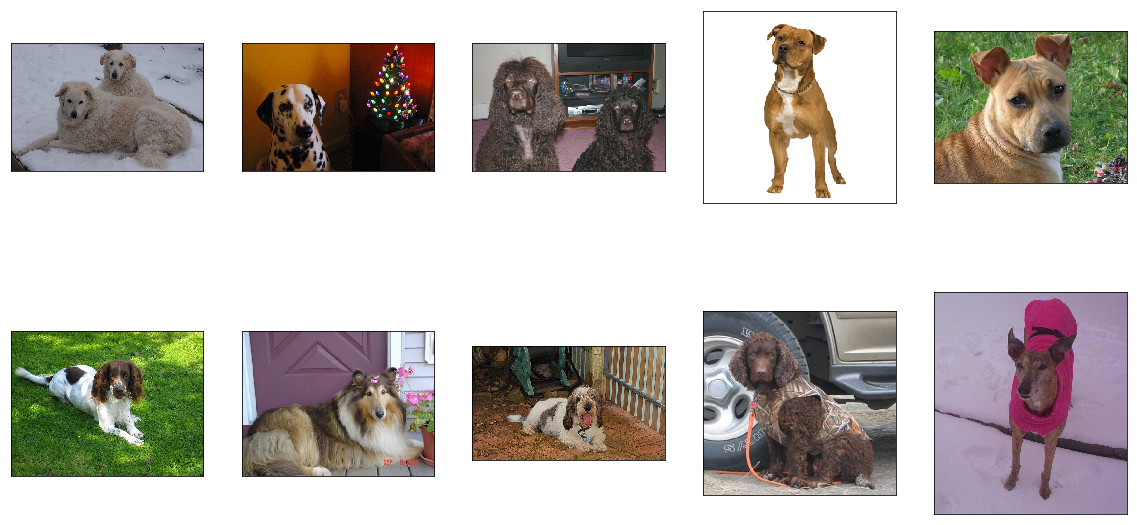

In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    """
    Visualize the image that is stored in the file path
    Parameters:
        img_path: a string-valued file path to an image
        ax: object or array of Axes objects
    Return:
        None
    """
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig = plt.figure(figsize=(20, 10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    visualize_img(train_files[i], ax)

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [6]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


### Visualize the Training human Image

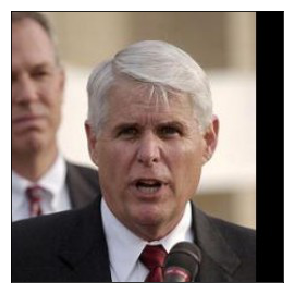

In [7]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
visualize_img(human_files[0], ax)

---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [8]:
def show_bounding_box_4_detected_face(img_path):
    """
    Display bounding boxs for each detected face in an image
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        None
    """
    # extract pre-trained face detector
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

    # load color (BGR) image
    img = cv2.imread(img_path)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # print number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),5)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb);

Number of faces detected: 1


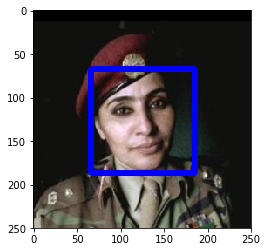

In [9]:
show_bounding_box_4_detected_face(human_files[3])

In [10]:
def show_bounding_box_4_detected_face_pass_img(img):
    """
    Display bounding boxs for each detected face in an image
    Parameters:
        img: a color (BGR) image has been read by OpenCV 
    Return:
        None
    """
    
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),5)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [11]:
def OpenCV_face_detector(img_path):
    """
    Detect whether if any faces in an image
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        True: if face is detected in image stored at img_path  
        False: if face is NOT detected in image stored at img_path 
    """
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray) # face position (x, y, w, h)
    return len(faces) > 0

In [12]:
def Improved_OpenCV_face_detector(img_path):
    """
    Detect whether if any faces in an image
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        faces: number of faces that have been detected in an image
        img: a color (BGR) image has been read by OpenCV 
    """
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
    img = cv2.imread(img_path) #BGR image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return faces, img

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
100 percentage of the first 100 images in `human_files` with a detected human face. However, 11 percentage of the first 100 images in `dog_files` have a detected human face. It shows that the face detector did well on human images, but it missclassified some images on dog files as human face.


In [13]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]


def OpenCV_face_detector_performance(img_path):
    """
    Test the performance of the face_detector algorithm on the images in human_files_short and dog_files_short.
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        accuracy of face detection performance in percentage
    """
    count = 0
    for img in img_path:
        if(OpenCV_face_detector(img)):
            count += 1
    return (count/len(img_path))*100

human_files_performance = OpenCV_face_detector_performance(human_files_short)
dog_files_performance = OpenCV_face_detector_performance(dog_files_short)
print("OpenCV face detector performace on human files is {:.0f}%".format(human_files_performance))
print("OpenCV face detector performace on dog files is {:.0f}%".format(dog_files_performance))

OpenCV face detector performace on human files is 100%
OpenCV face detector performace on dog files is 11%


11 dog images are misclassified as human face.


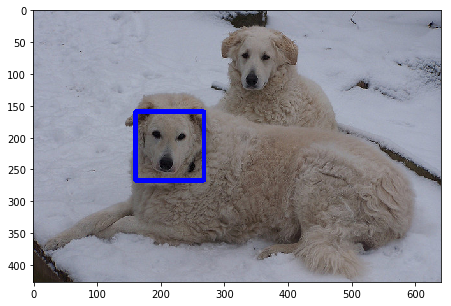

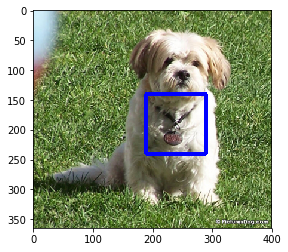

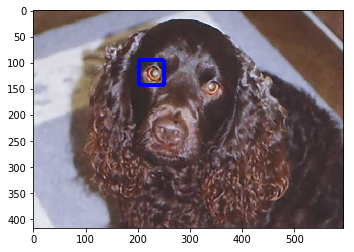

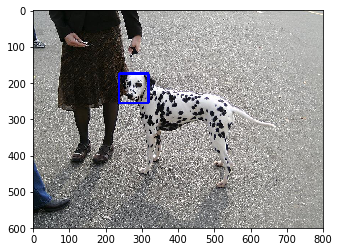

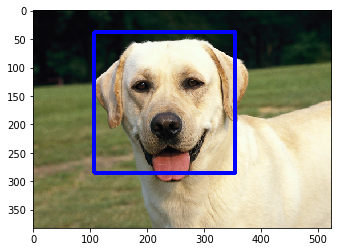

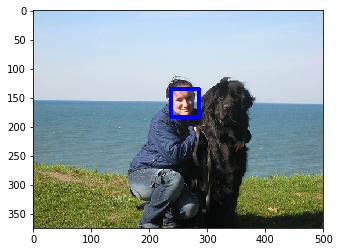

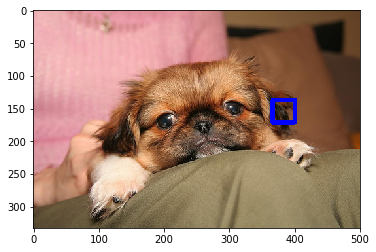

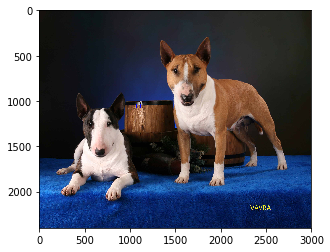

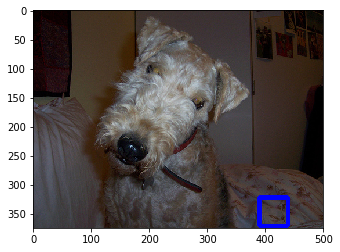

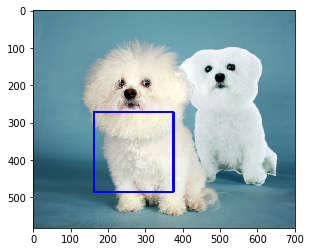

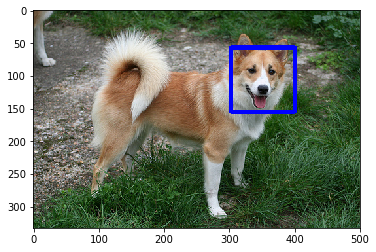

In [14]:
def show_misclassified_imgs(img_path):
    """
    Display images that are missclassified by the face_detector algorithm in dog_files_short.
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        None
    """
    misclassified_imgs = []
   
    for img in img_path:
        faces, img = Improved_OpenCV_face_detector(img)
        # create a image list of misclassified images
        if(len(faces)):
            misclassified_imgs.append(img)
    print(len(misclassified_imgs), "dog images are misclassified as human face.")
    
    # show misclassifed imgs
    fig = plt.figure(figsize=(10, 5))
    for i in range(len(misclassified_imgs)):
        show_bounding_box_4_detected_face_pass_img(misclassified_imgs[i])
        plt.figure(i+1);
        plt.show();
        
dog_files_short = train_files[:100]
show_misclassified_imgs(dog_files_short)

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__
It is not a reasonable expectation to pose on the user to provide a image with a clearly presented face. In some cases, people may need to shoot moving subjects or have no high resolution devices supported. Therefore, they might not be able to provide clear images all the time.
We can preprocess our images by adding some noise to simulate the images which can not show clear faces such as low resolution, blurring, etc. Then train our network model to recognize those images with unclear faces. By this way, our face recoginition app will be more user-friendly.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

### Another approach: Face Recognition in Python

In [ ]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

In [ ]:
import face_recognition
image = face_recognition.load_image_file(human_files[3])
face_locations = face_recognition.face_locations(image)

In [ ]:
# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
face_locations = face_recognition.face_locations(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(face_locations))

# get bounding box for each detected face
for (top,right,bottom,left) in face_locations:
    # add bounding box to color image
    cv2.rectangle(img,(left,top),(right,bottom),(255,0,0),2) # (255,0,0) is bounding box color, 2 is bounding box line width
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [ ]:
def face_recognition_detector(img_path):
    """
    Detect whether of any faces in an image
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        True: if face is detected in image stored at img_path  
        False: if face is NOT detected in image stored at img_path 
    """
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_recognition.face_locations(gray)
    return len(faces) > 0

In [ ]:
def face_recognition_detector_performance(img_path):
    """
    Test the performance of the face_detector algorithm on the images in human_files_short and dog_files_short.
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        accuracy of face detection performance in percentage
    """
    count = 0
    for img in img_path:
        if(face_recognition_detector(img)):
            count += 1
    return (count/len(img_path))*100

human_files_performance = face_recognition_detector_performance(human_files_short)
dog_files_performance = face_recognition_detector_performance(dog_files_short)
print("face detector performace on human files is {:.0f}%".format(human_files_performance))
print("face detector performace on dog files is {:.0f}%".format(dog_files_performance))

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [15]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 2s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [16]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    """
    Convert a color image to a 4D tensor with shape (1, 224, 224, 3) to supply Keras CNN
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        a 4D tensor suitable with shape (1, 224, 224, 3)
    """
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """
    Convert color images to a 4D tensor with shape of (nb_samples, 224, 224, 3) 
    Parameters:
        img_paths: a numpy array of string-valued image paths
    Return:
        4D tensor with shape (nb_samples,224,224,3).
    """
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [17]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    """
    Use the model to extract the predictions and get the highest predicted object classes
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        an integer corresponding to the model's predicted object class     
    """
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [18]:
def dog_detector(img_path):
    """
    Detect whether if any dogs in the images
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        True: if a dog is detected in an image
        False: if a dog is NOT detected in an image
    """
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 100 percentage of the first 100 images in `dog_files_short` have been detected with dogs and no image in `human_files_short` is misclassified as a dog. It shows that the dog detector did well on both of human and dogs images.

In [19]:
def dog_detector_performance(img_path):
    """
    Test the performance of the dog_detector algorithm on the images in human_files_short and dog_files_short.
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        accuracy of face detection performance in percentage
    """
    count = 0
    for img in img_path:
        if(dog_detector(img)):
            count += 1
    return (count/len(img_path))*100

human_files_performance = dog_detector_performance(human_files_short)
dog_files_performance = dog_detector_performance(dog_files_short)
print("dog detector performace on human files is {:.0f}%".format(human_files_performance))
print("dog detector performace on dog files is {:.0f}%".format(dog_files_performance))

dog detector performace on human files is 0%
dog detector performace on dog files is 100%


### ResNet50.py

In [20]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image  

ResNet50_model = ResNet50(weights='imagenet')

class ResNet50:
    def __init__(self):
        pass
     
    def path_to_tensor(self, img_path):
        """
        Convert a color image to a 4D tensor with shape (1, 224, 224, 3) to supply Keras CNN
        Parameters:
            img_path: a string-valued file path to an image
        Return:
            a 4D tensor suitable with shape (1, 224, 224, 3)
        """
        # loads RGB image as PIL.Image.Image type
        img = image.load_img(img_path, target_size=(224, 224))
        # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
        x = image.img_to_array(img)
        # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor 
        return np.expand_dims(x, axis=0)
        

    def ResNet50_predict_labels(self, img_path):
        """
        Use the model to extract the predictions and get the highest predicted object classes
        Parameters:
            img_path: a string-valued file path to an image
        Return:
            an integer corresponding to the model's predicted object class     
        """
        ResNet50_model = self.load_ResNet50_model()
        # returns prediction vector for image located at img_path
        img = preprocess_input(self.path_to_tensor(img_path))
        return np.argmax(ResNet50_model.predict(img))


    def dog_detector(self, img_path):
        """
        Detect whether if any dogs in the images
        Parameters:
            img_path: a string-valued file path to an image
        Return:
            True: if a dog is detected in an image
            False: if a dog is NOT detected in an image
        """
        prediction = ResNet50_predict_labels(img_path)
        return ((prediction <= 268) & (prediction >= 151)) 
    
    def dog_detector_performance(self, img_path):
        """
        Test the performance of the dog_detector algorithm on the images in human_files_short and dog_files_short.
        Parameters:
            img_path: a string-valued file path to an image
        Return:
            accuracy of face detection performance in percentage
        """
        count = 0
        for img in img_path:
            if(self.dog_detector(img)):
                count += 1
        return (count/len(img_path))*100

In [21]:
r = ResNet50()
human_files_performance = r.dog_detector_performance(human_files_short)
dog_files_performance = r.dog_detector_performance(dog_files_short)
print("dog detector performace on human files is {:.0f}%".format(human_files_performance))
print("dog detector performace on dog files is {:.0f}%".format(dog_files_performance))

dog detector performace on human files is 0%
dog detector performace on dog files is 100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [22]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:09<00:00, 86.82it/s] 


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__  
epoch = 10;  Test accuracy: 3.9474%


| Layers                  | Output Shape          |
|-------------------------|-----------------------|
|  Conv2D                 | (None, 224, 224, 16)  |
|  MaxPooling2D           | (None, 112, 112, 16)  |
|  Conv2D                 | (None, 112, 112, 32)  |
|  MaxPooling2D           | (None,  56,  56, 32)  |
|  Conv2D                 | (None,  56,  56, 64)  |
|  MaxPooling2D           | (None,  28,  28, 64)  |
|  GlobalAveragePooling2D | (None,  64)           |
|  Dense                  | (None,  133)          |




In [26]:
# epochs = 5 => Test accuracy: 2.8708%%
# epochs = 10 => Test accuracy: 4.3062%
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### Define architecture.
model.add(Conv2D(filters=16, kernel_size=2, activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
__________

In [40]:
### Change kernel_size = 3 ###
# epochs = 5 => Test accuracy: 2.3923%
# epochs = 10 => Test accuracy: 4.4258%
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

## Define architecture.
model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [25]:
##################################
##                              ##
## Best Model with epoches = 10 ##
##                              ##
##################################
### Change padding = SAME ###
# epochs = 5 => Test accuracy: 2.1531%
# epochs = 10 => Test accuracy: 3.9474%

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

## Define architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [56]:
### Add FC layers ###
# epochs = 5 => Test accuracy: 2.0335%
# epochs = 10 => Test accuracy: 2.9904%

model = Sequential()

## Define architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_8 ( (None, 64)                0         
__________

### Compile the Model

In [26]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [27]:
from keras.callbacks import ModelCheckpoint  

#the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 23s 3ms/step - loss: 4.8838 - acc: 0.0094 - val_loss: 4.8691 - val_acc: 0.0120
Epoch 2/10
6680/6680 [==============================] - 22s 3ms/step - loss: 4.8629 - acc: 0.0129 - val_loss: 4.8525 - val_acc: 0.0168
Epoch 3/10
6680/6680 [==============================] - 22s 3ms/step - loss: 4.8240 - acc: 0.0171 - val_loss: 4.8221 - val_acc: 0.0144
Epoch 4/10
6680/6680 [==============================] - 22s 3ms/step - loss: 4.7859 - acc: 0.0186 - val_loss: 4.7944 - val_acc: 0.0192
Epoch 5/10
6680/6680 [==============================] - 22s 3ms/step - loss: 4.7557 - acc: 0.0225 - val_loss: 4.7704 - val_acc: 0.0263
Epoch 6/10
6680/6680 [==============================] - 22s 3ms/step - loss: 4.7234 - acc: 0.0253 - val_loss: 4.7576 - val_acc: 0.0347
Epoch 7/10
6680/6680 [==============================] - 22s 3ms/step - loss: 4.6947 - acc: 0.0295 - val_loss: 4.7288 - val_acc: 0.0263
Epoch 8/

### Load the Model with the Best Validation Loss

In [28]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [29]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.9474%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [61]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [62]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_9 ( (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [63]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [64]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 360us/step - loss: 12.5898 - acc: 0.1126 - val_loss: 10.9924 - val_acc: 0.2168
Epoch 2/20
6680/6680 [==============================] - 2s 262us/step - loss: 10.5533 - acc: 0.2609 - val_loss: 10.4120 - val_acc: 0.2683
Epoch 3/20
6680/6680 [==============================] - 2s 265us/step - loss: 10.0910 - acc: 0.3175 - val_loss: 10.2022 - val_acc: 0.2922
Epoch 4/20
6680/6680 [==============================] - 2s 263us/step - loss: 9.7231 - acc: 0.3451 - val_loss: 9.8150 - val_acc: 0.3174
Epoch 5/20
6680/6680 [==============================] - 2s 290us/step - loss: 9.4182 - acc: 0.3744 - val_loss: 9.5652 - val_acc: 0.3485
Epoch 6/20
6680/6680 [==============================] - 2s 290us/step - loss: 9.2774 - acc: 0.3979 - val_loss: 9.5239 - val_acc: 0.3461
Epoch 7/20
6680/6680 [==============================] - 2s 291us/step - loss: 9.1697 - acc: 0.4064 - val_loss: 9.5054 - val_acc: 0.

### Load the Model with the Best Validation Loss

In [65]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [66]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 41.1483%


### Predict Dog Breed with the Model

In [67]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    """
    Use VGG16 model to predicte dog breed
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        return dog breed that is predicted by the model
    """
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras.  These are already in the workspace, at /data/bottleneck_features.  If you wish to download them on a different machine, they can be found at:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

The above architectures are downloaded and stored for you in the `/data/bottleneck_features/` folder.

This means the following will be in the `/data/bottleneck_features/` folder:

`DogVGG19Data.npz`
`DogResnet50Data.npz`
`DogInceptionV3Data.npz`
`DogXceptionData.npz`



### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('/data/bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [32]:
### Obtain bottleneck features from InceptionV3 pre-trained CNN.
bottleneck_features = np.load('/data/bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

##### Step 1: Build different architectures

_Architecture 1_:

| Layers                  | Output Shape          |  
|-------------------------|-----------------------|  
|  GlobalAveragePooling2D | (None,  2048)         |  
|  Dense                  | (None,  133)          |  

_Architecture 2_: add hidden layer in classifier
 
| Layers                  | Output Shape          |
|-------------------------|-----------------------|
|  GlobalAveragePooling2D | (None,  2048)         |
|  Dense                  | (None,  128)          |
|  Dense                  | (None,  133)          |

Test accuracy:

| Architecture 1                         | Architecture 2                          |  
|----------------------------------------|-----------------------------------------|
| 80.0239% (epoch = 5,  batch_size = 20) | 78.4689% (epoch = 5,  batch_size = 20)  |   
| 80.6220% (epoch = 10, batch_size = 20) | 80.8612% (epoch = 10, batch_size = 20)  |  
| 80.5024% (epoch = 20, batch_size = 20) | 80.6220% (epoch = 20, batch_size = 20)  |  
| 77.6316% (epoch = 25, batch_size = 20) | 80.0239% (epoch = 25, batch_size = 20)  |  

_Result1_:
It shows that Architecture 1 and Architecture 2 have better performance as epoch is 10. But can't tell 
which architecture has better performance at this point. Will keep both and try different parameters.

##### Step 2: Test on augmented images

Test accuracy:

| Architecture 1                         | Architecture 2                          |  
|----------------------------------------|-----------------------------------------|
| 76.9139% (epoch = 5,  batch_size = 20) | 79.9043% (epoch = 5,  batch_size = 20)  |   
| 80.6220% (epoch = 10, batch_size = 20) | 79.5455% (epoch = 10, batch_size = 20)  |  
| 80.7416% (epoch = 15, batch_size = 20) | N/A      (epoch = 20, batch_size = 20)  |    
 
_Result2_:
It shows that Architecture 1 have better performance on test augmented images than Architecture 1 as epoch is more than 10. Therefore, I will choose Architecture 1 as model to tune other hyperparameters.

##### Step 3: Try different batch sizes

Test accuracy:

| Architecture 1                          |
|-----------------------------------------|
| 80.6220% (epoch = 10, batch_size =  20) |   
| 80.3828% (epoch = 10, batch_size =  30) |
| 82.0574% (epoch = 10, batch_size =  40) | 
| 81.5789% (epoch = 10, batch_size =  60) | 
| 81.4593% (epoch = 10, batch_size = 120) | 

 
_Result3_:
It shows that Architecture 1 have better performance as batch_size is 40. 

##### Step 4: Test on augmented images with epoch=10, batch_size=40 by model of Architecture 1   

Test accuracy:

| w/o augmented images |w/ augmented images |
|----------------------|--------------------|
| 82.0574%             | 82.0574%           |

_Result4_:
It turns out the model has the same performance on either original images or augmented images.
Because it is hard to expect what kind of images users will used to test, I will take the weights 
which is tested on augmented images as final model weights.


In [33]:
###################################################
##                                               ##
## Best Model with epoches = 10, batch_size = 40 ##
##                                               ##
###################################################

### test w/o augmented image ###
# epoch = 5, batch_size = 20, Test accuracy:80.0239%
# epoch = 10, batch_size = 20, Test accuracy: 80.6220%
# epoch = 20, batch_size = 20, Test accuracy: 80.5024%
# epoch = 25, batch_size = 20, Test accuracy: 77.6316%
# epoch = 10, batch_size = 30, Test accuracy: 80.3828%
# epoch = 10, batch_size = 40, Test accuracy: 82.0574% => best
# epoch = 10, batch_size = 60, Test accuracy: 81.5789%
# epoch = 10, batch_size = 120, Test accuracy: 81.4593%

### test w/ augmented images ###
# epoch = 5, batch_size = 20, Test accuracy:76.9139%
# epoch = 10, batch_size = 20, Test accuracy: 80.6220%
# epoch = 15, batch_size = 20, Test accuracy: 80.7416%
# epoch = 10, batch_size = 40, Test accuracy: 82.0574% => best => final save weights for model

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
### Define architecture.
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [21]:
#####Add more fc layers#####
### no augmented image ###
# epoch = 5, batch_size = 20, Test accuracy: 78.4689%
# epoch = 10, batch_size = 20, Test accuracy: 80.8612%
# epoch = 20, batch_size = 20, Test accuracy: 80.6220%
# epoch = 25, batch_size = 20, Test accuracy: 80.0239%

### test w/ augmented images ###
# epoch = 5, batch_size = 20, Test accuracy: 79.9043%
# epoch = 10, batch_size = 20, Test accuracy: 79.5455%
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dense(128, activation='relu'))
InceptionV3_model.add(Dropout(0.5))
InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 133)               17157     
Total params: 279,429
Trainable params: 279,429
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [19]:
### Compile the model.
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Create and configure augmented image generator

In [193]:
from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

### Visualize Oroginal and Augmented Images

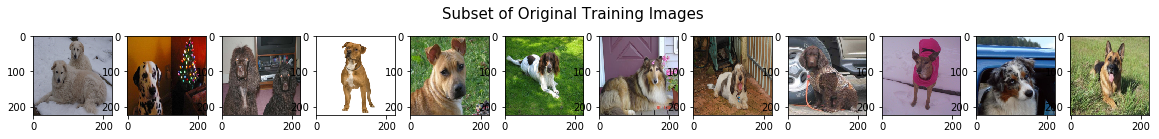

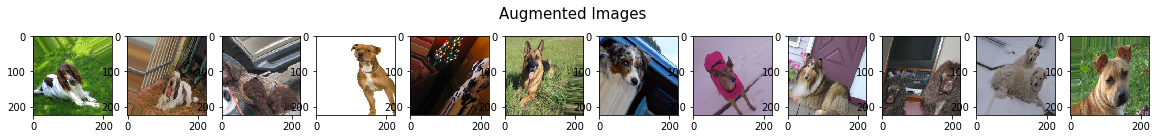

In [122]:
x_train_subset = train_tensors[:12]

fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])

fig.suptitle("Subset of Original Training Images", fontsize=15)
plt.show()

fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, len(x_train_subset)):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle("Augmented Images", fontsize=15)
    plt.show()
    break;

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [188]:
### Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=10, batch_size=30, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 3s 471us/step - loss: 1.2133 - acc: 0.7034 - val_loss: 0.6492 - val_acc: 0.8072
Epoch 2/10
6680/6680 [==============================] - 2s 284us/step - loss: 0.4539 - acc: 0.8573 - val_loss: 0.6433 - val_acc: 0.8192
Epoch 3/10
6680/6680 [==============================] - 2s 283us/step - loss: 0.3338 - acc: 0.8957 - val_loss: 0.5848 - val_acc: 0.8335
Epoch 4/10
6680/6680 [==============================] - 2s 281us/step - loss: 0.2615 - acc: 0.9180 - val_loss: 0.6563 - val_acc: 0.8479
Epoch 5/10
6680/6680 [==============================] - 2s 282us/step - loss: 0.2128 - acc: 0.9326 - val_loss: 0.6613 - val_acc: 0.8479
Epoch 6/10
6680/6680 [==============================] - 2s 278us/step - loss: 0.1702 - acc: 0.9461 - val_loss: 0.6538 - val_acc: 0.8527
Epoch 7/10
6680/6680 [==============================] - 2s 276us/step - loss: 0.1439 - acc: 0.9548 - val_loss: 0.6879 - val_acc: 0.8419
E

### Train the Model with augmented images

In [200]:
batch_size=40
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

InceptionV3_model.fit_generator(datagen_train.flow(train_InceptionV3, train_targets, batch_size=batch_size),
                                steps_per_epoch= train_InceptionV3.shape[0]//batch_size,
                                validation_data=(valid_InceptionV3, valid_targets),
                                epochs=10,callbacks=[checkpointer], verbose=1)

/opt/conda/lib/python3.6/site-packages/keras/preprocessing/image.py:855: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (6680, 5, 5, 2048) (2048 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/10
167/167 [==============================] - 298s 2s/step - loss: 1.2980 - acc: 0.6877 - val_loss: 0.6668 - val_acc: 0.8012
Epoch 2/10
167/167 [==============================] - 297s 2s/step - loss: 0.4747 - acc: 0.8487 - val_loss: 0.5851 - val_acc: 0.8275
Epoch 3/10
167/167 [==============================] - 299s 2s/step - loss: 0.3570 - acc: 0.8877 - val_loss: 0.5581 - val_acc: 0.8431
Epoch 4/10
167/167 [==============================] - 300s 2s/step - loss: 0.2817 - acc: 0.9079 - val_loss: 0.5902 - val_acc: 0.8443
Epoch 5/10
167/167 [==============================] - 300s 2s/step - loss: 0.2186 - acc: 0.9292 - val_loss: 0.6112 - val_acc: 0.8443
Epoch 6/10
167/167 [==============================] - 301s 2s/step - loss: 0.1864 - acc: 0.9361 - val_loss: 0.6435 - val_acc: 0.8407
Epoch 7/10
167/167 [==============================] - 299s 2s/step - loss: 0.1548 - acc: 0.9521 - val_loss: 0.6513 - val_acc: 0.8515
Epoch 8/10
167/167 [==============================] - 300s 2s/step - 

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [34]:
### Load the model weights with the best validation loss.
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [35]:
### Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.0574%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [36]:
from extract_bottleneck_features import *

def InceptionV3_predict_breed(img_path):
    """
    Use InceptionV3 model to predicte dog breed
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        return dog breed that is predicted by the model
    """
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [37]:
from extract_bottleneck_features import *

def InceptionV3_predict_top5_breeds(img_path):
    """
    Use InceptionV3 model to predicte dog breed and return top5 predicted breeds 
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        top5_breeds_idx: top5 dog breed idx that is predicted by the model
        top5_breeds_prob: top5 dog breed probabilities that are corresponding to top5 dog breed idx    
    """
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    # np.argsort(-predicted_vector) return matrix shape (1, 133)
    top5_breeds_idx= np.argsort(-predicted_vector)[0][:5] # return top5 probability class idx
    top5_breeds_prob= [predicted_vector[0][idx] for idx in top5_breeds_idx]# return top5 probability 
    return top5_breeds_idx, top5_breeds_prob

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

## Snapchat-like filter

In [68]:
# load dog_filter images
dog_left_ear  = cv2.imread('filters/dog_left_ear.png', cv2.IMREAD_UNCHANGED) # rgba
dog_right_ear = cv2.imread('filters/dog_right_ear.png',cv2.IMREAD_UNCHANGED)
dog_nose = cv2.imread('filters/dog_nose.png', cv2.IMREAD_UNCHANGED)
dog_tongue = cv2.imread('filters/dog_tongue.png', cv2.IMREAD_UNCHANGED)

In [69]:
def resize_filter(img, w):
    """
    Adjust the size of filter images according to the size of the detected face on the test image
    Parameters:
        img: images that has read by OpenCV (BGR image)
        w: width of bounding box for the detected face
    Return:
        img: resized image
    """
    new_w = int(w*0.3) # resize the image to 0.3 scale of the width of the face detector 
    new_h = int(img.shape[0]/img.shape[1]*new_w) # keep aspect ratio
    img = cv2.resize(img, (new_w, new_h))
    return img

In [70]:
def put_dog_left_ear(dog_left_ear_img, human_img, x, y, w, h):
    """
    Overlay dog_left_ear filter image to the detected faces on human images
    Parameters:
        dog_left_ear_img: filter image with dog left ear
        human_img: input image for the classifier
        x, y : coordinates of the bounding box for the detected face at the top right corner
        w: width of bounding box for the detected face
        h: height of bounding box for the detected face
    Return:
        human_img: human image with dog left ear filter
    """ 
    
    dog_leftEar_img = resize_filter(dog_left_ear_img, w)
    #overlay range
    yo = dog_leftEar_img.shape[0]
    xo = dog_leftEar_img.shape[1]
    #loop every pixel
    for j in range(yo):
        for i in range(xo):
            for k in range(3):
                alpha = float(dog_leftEar_img[j][i][3]/255.0) # read the alpha channel 
                #human_img[x + i][y + j][k] = dog_ear_img[i][j][k] # with black background if w/o alpha
                human_img[y+j][x+i][k] = alpha*dog_leftEar_img[j][i][k]+(1-alpha)*human_img[y+j][x+i][k]
    return human_img

In [71]:
def put_dog_right_ear(dog_right_ear_img, human_img, x, y, w, h):
    """
    Overlay dog_right_ear filter image to the detected faces on human images
    Parameters:
        dog_right_ear_img: filter image with dog right ear
        human_img: input image for the classifier
        x, y : coordinates of the bounding box for the detected face at the top right corner
        w: width of bounding box for the detected face
        h: height of bounding box for the detected face
    Return:
        human_img: human image with dog right ear filter
    """ 
    
    dog_rightEar_img = resize_filter(dog_right_ear_img, w)
    #overlay range
    yo = dog_rightEar_img.shape[0]
    xo = dog_rightEar_img.shape[1]
    #loop every pixel
    for j in range(yo):
        for i in range(xo):
            for k in range(3):
                alpha = float(dog_rightEar_img[j][i][3]/255.0) # read the alpha channel 
                human_img[y+j][x+w-xo+i][k] = alpha*dog_rightEar_img[j][i][k]+(1-alpha)*human_img[y+j][x+w-xo+i][k]
    return human_img

In [72]:
def put_dog_nose(dog_nose_img, human_img, x, y, w, h):
    """
    Overlay dog_nose filter image to the detected faces on human images
    Parameters:
        dog_nose_img: filter image with dog nose
        human_img: input image for the classifier
        x, y : coordinates of the bounding box for the detected face at the top right corner
        w: width of bounding box for the detected face
        h: height of bounding box for the detected face
    Return:
        human_img: human image with dog nose filter
    """ 
    
    dog_Nose_img = resize_filter(dog_nose_img, w)
    #overlay range
    yo = dog_Nose_img.shape[0]
    xo = dog_Nose_img.shape[1]
    #loop every pixel
    for j in range(yo):
        for i in range(xo):
            for k in range(3):
                alpha = float(dog_Nose_img[j][i][3]/255.0) # read the alpha channel 
                human_img[y+int(h/2)+j][x+int((w-xo)/2)+i][k] = alpha*dog_Nose_img[j][i][k]+\
                                                        (1-alpha)*human_img[y+int(h/2)+j][x+int((w-xo)/2)+i][k]
    return human_img

In [73]:
def put_dog_tongue(dog_tongue_img, human_img, x, y, w, h):
    """
    Overlay dog_tongue filter image to the detected faces on human images
    Parameters:
        dog_tongue_img: filter image with dog tongue
        human_img: input image for the classifier
        x, y : coordinates of the bounding box for the detected face at the top right corner
        w: width of bounding box for the detected face
        h: height of bounding box for the detected face
    Return:
        human_img: human image with dog tongue filter
    """ 
    
    dog_Tongue_img = resize_filter(dog_tongue_img, w)
    #overlay range
    yo = dog_Tongue_img.shape[0]
    xo = dog_Tongue_img.shape[1]
    #loop every pixel
    for j in range(yo):
        for i in range(xo):
            for k in range(3):
                alpha = float(dog_Tongue_img[j][i][3]/255.0) # read the alpha channel 
                human_img[y+h-yo+j][x+int((w-xo)/2)+i][k] = alpha*dog_Tongue_img[j][i][k]+\
                                                        (1-alpha)*human_img[y+h-yo+j][x+int((w-xo)/2)+i][k]
    return human_img

In [74]:
def apply_snapchat_filter(img_path):
    """
    Overlay  dog filter images(left_ear, right_ear, nose, tongue) to the detected faces on human images
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        None   
    """
    
    # extract pre-trained face detector
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

    # load color (BGR) image
    img = cv2.imread(img_path)

    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    face = face_cascade.detectMultiScale(gray)

    # add overlayer
    for (x,y,w,h) in face:
        img = put_dog_left_ear(dog_left_ear, img, x, y, w, h)
        img = put_dog_right_ear(dog_right_ear, img, x, y, w, h)
        img = put_dog_nose(dog_nose, img, x, y, w, h)
        img = put_dog_tongue(dog_tongue, img, x, y, w, h)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    plt.imshow(cv_rgb)

### Dog_filters.py

In [40]:
import cv2
import matplotlib.pyplot as plt

dog_left_ear  = cv2.imread('filters/dog_left_ear.png', cv2.IMREAD_UNCHANGED) # rgba
dog_right_ear = cv2.imread('filters/dog_right_ear.png',cv2.IMREAD_UNCHANGED)
dog_nose = cv2.imread('filters/dog_nose.png', cv2.IMREAD_UNCHANGED)
dog_tongue = cv2.imread('filters/dog_tongue.png', cv2.IMREAD_UNCHANGED)

dog_filters = [dog_left_ear, dog_right_ear, dog_nose, dog_tongue]

class Dog_filters:
    def __init__(self, face_img_path, scale=0.3):
        self.face_img_path = face_img_path
        self.face_img = cv2.imread(self.face_img_path) # load color (BGR) image
        self.scale = scale
        self.resize_filters=[]


    def resize_filter(self, w):
        """
        Adjust the size of filter images according to the size of the detected face on the test image
        Parameters:
            img: images that has read by OpenCV (BGR image)
            w: width of bounding box for the detected face
        Return:
            img: resized image
        """
        for dog_filter in dog_filters:
            new_w = int(w*0.3) # resize the image to 0.3 scale of the width of the face detector
            new_h = int(dog_filter.shape[0]/dog_filter.shape[1]*new_w) # keep aspect ratio
            resize_filter = cv2.resize(dog_filter, (new_w, new_h))
            self.resize_filters.append(resize_filter)


    def put_dog_left_ear(self, x, y):
        """
        Overlay dog_left_ear filter image to the detected faces on human images
        Parameters:
            dog_left_ear_img: filter image with dog left ear
            human_img: input image for the classifier
            x, y : coordinates of the bounding box for the detected face at the top right corner
            w: width of bounding box for the detected face
            h: height of bounding box for the detected face
        Return:
            human_img: human image with dog left ear filter
        """ 
        dog_left_ear_filter = self.resize_filters[0]

        #overlay range
        yo = dog_left_ear_filter.shape[0]
        xo = dog_left_ear_filter.shape[1]
        #loop every pixel
        for j in range(yo):
            for i in range(xo):
                for k in range(3):
                    alpha = float(dog_left_ear_filter[j][i][3]/255.0) # read the alpha channel
                    #self.face_img[x + i][y + j][k] = dog_left_ear_filter[i][j][k] # with black background if w/o alpha
                    self.face_img[y+j][x+i][k] = alpha*dog_left_ear_filter[j][i][k]+(1-alpha)*self.face_img[y+j][x+i][k]



    def put_dog_right_ear(self, x, y, w, h):
        """
        Overlay dog_right_ear filter image to the detected faces on human images
        Parameters:
            dog_right_ear_img: filter image with dog right ear
            human_img: input image for the classifier
            x, y : coordinates of the bounding box for the detected face at the top right corner
            w: width of bounding box for the detected face
            h: height of bounding box for the detected face
        Return:
            human_img: human image with dog right ear filter
        """ 
        dog_right_ear_filter = self.resize_filters[1]

        #overlay range
        yo = dog_right_ear_filter.shape[0]
        xo = dog_right_ear_filter.shape[1]
        #loop every pixel
        for j in range(yo):
            for i in range(xo):
                for k in range(3):
                    alpha = float(dog_right_ear_filter[j][i][3]/255.0) # read the alpha channel
                    self.face_img[y+j][x+w-xo+i][k] = alpha*dog_right_ear_filter[j][i][k]+(1-alpha)*self.face_img[y+j][x+w-xo+i][k]




    def put_dog_nose(self, x, y, w, h):
        """
        Overlay dog_nose filter image to the detected faces on human images
        Parameters:
            dog_nose_img: filter image with dog nose
            human_img: input image for the classifier
            x, y : coordinates of the bounding box for the detected face at the top right corner
            w: width of bounding box for the detected face
            h: height of bounding box for the detected face
        Return:
            human_img: human image with dog nose filter
        """ 
        dog_nose_filter = self.resize_filters[2]
        #overlay range
        yo = dog_nose_filter.shape[0]
        xo = dog_nose_filter.shape[1]
        #loop every pixel
        for j in range(yo):
            for i in range(xo):
                for k in range(3):
                    alpha = float(dog_nose_filter[j][i][3]/255.0) # read the alpha channel
                    self.face_img[y+int(h/2)+j][x+int((w-xo)/2)+i][k] = alpha*dog_nose_filter[j][i][k]+\
                                                            (1-alpha)*self.face_img[y+int(h/2)+j][x+int((w-xo)/2)+i][k]




    def put_dog_tongue(self, x, y, w, h):
        """
        Overlay dog_tongue filter image to the detected faces on human images
        Parameters:
            dog_tongue_img: filter image with dog tongue
            human_img: input image for the classifier
            x, y : coordinates of the bounding box for the detected face at the top right corner
            w: width of bounding box for the detected face
            h: height of bounding box for the detected face
        Return:
            human_img: human image with dog tongue filter
        """ 
        dog_nose_filter = self.resize_filters[3]
        #overlay range
        yo = dog_nose_filter.shape[0]
        xo = dog_nose_filter.shape[1]
        #loop every pixel
        for j in range(yo):
            for i in range(xo):
                for k in range(3):
                    alpha = float(dog_nose_filter[j][i][3]/255.0) # read the alpha channel
                    self.face_img[y+h-yo+j][x+int((w-xo)/2)+i][k] = alpha*dog_nose_filter[j][i][k]+\
                                                            (1-alpha)*self.face_img[y+h-yo+j][x+int((w-xo)/2)+i][k]



    def apply_snapchat_filter(self):
        """
        Overlay  dog filter images(left_ear, right_ear, nose, tongue) to the detected faces on human images
        Parameters:
            img_path: a string-valued file path to an image
        Return:
            None   
        """
        # extract pre-trained face detector
        face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

        # convert BGR image to grayscale
        gray = cv2.cvtColor(self.face_img, cv2.COLOR_BGR2GRAY)

        # find faces in image
        face = face_cascade.detectMultiScale(gray)

        # add overlayer
        for (x,y,w,h) in face:
            self.resize_filter(w)
            self.put_dog_left_ear(x, y)
            self.put_dog_right_ear(x, y, w, h)
            self.put_dog_nose(x, y, w, h)
            self.put_dog_tongue(x, y, w, h)
        cv_rgb = cv2.cvtColor(self.face_img, cv2.COLOR_BGR2RGB)
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
        plt.imshow(cv_rgb)

### Visualize snapchat-like filter on human face

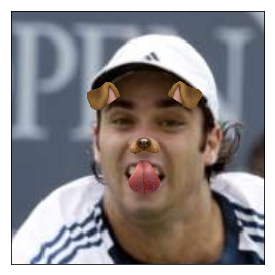

In [41]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

df = Dog_filters(human_files[40])
df.apply_snapchat_filter()


In [36]:
def isMix_mutt(top5_breeds_prob, top5_labels):
    """
        Decide whether if the detected dog/human is resemble to mix mutt dog breeds or not.
        If the difference of top 1 probability and top 2 probability is less than 0.1, it will be classified as 
        mix mutt.
        Parameters:
            top5_breeds_prob: top5 dog breed probabilities that is predicted by the model
            top5_labels: top5 dog breed labels that are corresponding to top5 dog breed idx 
        Return:
            None   
        """
    if (top5_breeds_prob[0] - top5_breeds_prob[1] <= 0.1):
        print("You look like", top5_labels[0], '&', top5_labels[1] ,"mixed breed dog!")
    else:
        print("You look like", top5_labels[0], "!")

In [81]:
def show_top5_result(img_path):
    """
    Visualize top 5 dog breeds that are predicted by the model via bar chart 
    Parameters:
        None 
    Return:
        None
    """
    top5_breeds_idx, top5_breeds_prob = InceptionV3_predict_top5_breeds(img_path)
    top5_labels = [dog_names[idx] for idx in top5_breeds_idx]
    isMix_mutt(top5_breeds_prob, top5_labels)
    
    #plot top5 result
    plt.subplot(1,2,1)
    plt.barh(top5_labels, top5_breeds_prob)
    plt.xlabel('probability')
    plt.xlim(0, 1.0)
    plt.title('dog breeds classifer')
    plt.show()

### InceptionV3.py

In [42]:
from dog_names import dog_names
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing import image
from extract_bottleneck_features import *
import numpy as np
import matplotlib.pyplot as plt

class InceptionV3:
    def __init__(self, img_path, InceptionV3_model=None, input_shape=(5,5,2048)):
        self.img_path = img_path
        if InceptionV3_model is None:
            model = Sequential()
            model.add(GlobalAveragePooling2D(input_shape = input_shape))
            model.add(Dense(133, activation='softmax'))
            model.load_weights('saved_models/weights.best.InceptionV3.hdf5')
            InceptionV3_model = model
        self.InceptionV3_model = InceptionV3_model
        self.input_shape = input_shape

    def path_to_tensor(self):
        """
        Convert a color image to a 4D tensor with shape (1, 224, 224, 3) to supply Keras CNN
        Parameters:
            img_path: a string-valued file path to an image
        Return:
            a 4D tensor suitable with shape (1, 224, 224, 3)
        """
        # loads RGB image as PIL.Image.Image type
        img = image.load_img(self.img_path, target_size=(224, 224))
        # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
        x = image.img_to_array(img)
        # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
        return np.expand_dims(x, axis=0)

    def predict_top5_breeds(self):
        """
        Use InceptionV3 model to predicte dog breed and return top5 predicted breeds 
        Parameters:
            None
        Return:
            top5_breeds_idx: top5 dog breed idx that is predicted by the model
            top5_breeds_prob: top5 dog breed probabilities that are corresponding to top5 dog breed idx    
        """
        # extract bottleneck features
        bottleneck_feature = extract_InceptionV3(self.path_to_tensor())
        # obtain predicted vector
        predicted_vector = self.InceptionV3_model.predict(bottleneck_feature)
        # return dog breed that is predicted by the model
        # np.argsort(-predicted_vector) return matrix shape (1, 133)
        top5_breeds_idx= np.argsort(-predicted_vector)[0][:5] # return top5 probability class idx
        top5_breeds_prob= [predicted_vector[0][idx] for idx in top5_breeds_idx]# return top5 probability
        return top5_breeds_idx, top5_breeds_prob

    def isMix_mutt(self, top5_breeds_prob, top5_labels):
        """
        Decide whether if the detected dog/human is resemble to mix mutt dog breeds or not.
        If the difference of top 1 probability and top 2 probability is less than 0.1, it will be classified as 
        mix mutt.
        Parameters:
            top5_breeds_prob: top5 dog breed probabilities that is predicted by the model
            top5_labels: top5 dog breed labels that are corresponding to top5 dog breed idx 
        Return:
            None   
        """
        if (top5_breeds_prob[0] - top5_breeds_prob[1] <= 0.1):
            print("You look like", top5_labels[0], '&', top5_labels[1] ,"mixed breed dog!")
        else:
            print("You look like", top5_labels[0], "!")

    def show_top5_result(self):
        """
        Visualize top 5 dog breeds that are predicted by the model via bar chart 
        Parameters:
            None 
        Return:
            None
        """
        top5_breeds_idx, top5_breeds_prob = self.predict_top5_breeds()
        top5_labels = [dog_names[idx] for idx in top5_breeds_idx]
        self.isMix_mutt(top5_breeds_prob, top5_labels)

        #plot top5 result
        plt.subplot(1,2,1)
        plt.barh(top5_labels, top5_breeds_prob)
        plt.xlabel('probability')
        plt.xlim(0, 1.0)
        plt.title('dog breeds classifer')
        plt.show()

### util/helper functions

In [39]:
def crop_detected_faces(BGR_img, faces):
    """
    Crop faces on the test human image
    Parameters:
        BGR_img: a color (BGR) image has been read by OpenCV 
        faces: number of faces that have been detected in an image
    Return:
        cropped_imgs: cropped images with detected faces
    """
    
    cropped_imgs = []
    offset = 25
    height, width = BGR_img.shape[:2]
    for i in range(len(faces)):
        x,y,w,h = faces[i]
        cropped_img = BGR_img[y-offset : y+h+offset, x-offset : x+w+offset]
        if(y-offset < 0):
            cropped_img = BGR_img[0 : y+h+offset, x-offset : x+w+offset]
        if(x-offset < 0):
            cropped_img = BGR_img[y-offset : y+h+offset, 0 : x+w+offset]
        if(y+h+offset > height):
            cropped_img = BGR_img[y-offset : height, 0 : x+w+offset]
        if(x+w+offset > width):
            cropped_img = BGR_img[y-offset : y+h+offset, 0 : width]
        cropped_imgs.append(cropped_img)
    return cropped_imgs

In [40]:
import os
def save_cropped_imgs(num, cropped_imgs):
    """
    Save cropped images to temp directory for later use
    Parameters:
        cropped_imgs: cropped images with detected faces
        num: number of cropped images from a test image
    Return:
        cropped_img_path: a string-valued file path to a cropped image
    """
    
    dirName = 'tempDir'
    if not os.path.exists(dirName):
        os.mkdir(dirName)

    cropped_img_path =  dirName + '/img' + str(num) + '.jpg'
    cv2.imwrite(cropped_img_path, cropped_imgs[num])
    return cropped_img_path

In [41]:
import glob
def delete_cropped_images():
    """
    Delete all files in temp directory
    Parameters:
        None
    Return:
        None
    """
    files = glob.glob('tempDir/*')
    for f in files:
        os.remove(f)

In [35]:
def show_test_image(img_path):
    """
    Display the test image on predicted result
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        None   
    """
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    visualize_img(img_path, ax)

### Predicted functions

In [38]:
def predict_breed(img_path):
    """
    Predict which dog breeds the image is resemble.
    if any face is detected, it will show "Hello, human!" and predict dog breeds result.
    if any dog is detected, it will show "Hello, dog!" and predict dog breeds result.
    if no dog and human are detected, it will show "No human. No dog." 
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        None
    """
    faces = OpenCV_face_detector(img_path)
    dogs = dog_detector(img_path)
    if(faces):
        print('Hello, human!')
        apply_snapchat_filter(img_path)
        show_top5_result(img_path)
    if(dogs):
        print('Hello, dog!')
        show_test_image(img_path)
        show_top5_result(img_path)
    if(faces == 0 and dogs == 0):
        print('No human. No dog.')
        show_test_image(img_path)


In [42]:
def detect_face_on_cropped_imgs(cropped_imgs):
    """
    Detect whether if any faces in an image
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        True: if face is detected in image stored at img_path  
        False: if face is NOT detected in image stored at img_path 
    """
    for i in range(len(cropped_imgs)):
        cropped_img_path = save_cropped_imgs(i, cropped_imgs)
        predict_breed_for_human_only(cropped_img_path)

In [43]:
def improved_predict_breed(img_path):
    """
    Predict which dog breeds the image is resemble.
    if dog and face are detected on the same image
        - predict dog breeds on the detected dog 
        - crop the detected face area on the image and predict dog breeds on the detected face
    
    if more than one detected faces on the same image
        - crop the detected face area on the image and predict dog breeds on the individual detected face
        
    if only one face is detected on the same image
        - predict dog breeds on the detected face
        
    if no dog and human are detected
        - print "No human. No dog." 
    
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        None
    """
    faces, BGR_img = Improved_OpenCV_face_detector(img_path)
    dogs = dog_detector(img_path)
    #if dog and human in the same image, model predicts dog breeds will always based on the dog
    #so we have to cropped the human image from the dog
    if(dogs != 0):
        print('Hello, dog!')
        show_test_image(img_path)
        show_top5_result(img_path)
        if(len(faces) > 0):
            cropped_imgs = crop_detected_faces(BGR_img, faces)
            detect_face_on_cropped_imgs(cropped_imgs)
            delete_cropped_images()
    #if more than one people in the same image, model predicts dog breeds will always show one result
    #so we have to crop the human image to individuals 
    else:
        if(len(faces) > 1):
            cropped_imgs = crop_detected_faces(BGR_img, faces)
            detect_face_on_cropped_imgs(cropped_imgs)
            delete_cropped_images()
        elif(len(faces) == 1): 
            print('Hello, human!')
            apply_snapchat_filter(img_path)
            show_top5_result(img_path)
        else:
            print('No human. No dog.')
            show_test_image(img_path)

In [44]:
def predict_breed_for_human_only(img_path):
    """
    Predict which dog breeds the cropped image is resemble.
    cropped image includes only one detected face, so no need to run the whole process in improved_predict_breed function
    Parameters:
        img_path: a string-valued file path to an image
    Return:
        None
    """
    faces, BGR_img = Improved_OpenCV_face_detector(img_path)
    print('Hello, human!')
    apply_snapchat_filter(img_path)
    show_top5_result(img_path)

### Predict_breeds.py

In [1]:
import dog_names as dn
from dog_filters import Dog_filters as df
from InceptionV3 import InceptionV3 as iV3
from ResNet50 import ResNet50 as rn50
import util as u

import numpy as np
import cv2


class Predict_breeds:
    def __init__(self, img_path):
        self.img_path = img_path
        
    def Improved_OpenCV_face_detector(self):
        """
        Detect whether if any faces in an image
        Parameters:
            img_path: a string-valued file path to an image
        Return:
            faces: number of faces that have been detected in an image
            img: a color (BGR) image has been read by OpenCV 
        """
        face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
        img = cv2.imread(self.img_path) #BGR image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray)
        return faces, img


    def predict_breed_for_human_only(self):
        """
        Predict which dog breeds the cropped image is resemble.
        cropped image includes only one detected face, so no need to run the whole process in improved_predict_breed function
        Parameters:
            img_path: a string-valued file path to an image
        Return:
            None
        """
        iV3_model = iV3(self.img_path)
        dog_filters = df(self.img_path)
        faces, BGR_img = self.Improved_OpenCV_face_detector()
        print('Hello, human!')
        dog_filters.apply_snapchat_filter()
        iV3_model.show_top5_result()   
    

    def detect_face_on_cropped_imgs(self, cropped_imgs):
        """
        Detect whether if any faces in an image
        Parameters:
            img_path: a string-valued file path to an image
        Return:
            True: if face is detected in image stored at img_path  
            False: if face is NOT detected in image stored at img_path 
        """
        for i in range(len(cropped_imgs)):
            cropped_img_path = u.save_cropped_imgs(i, cropped_imgs)
            self.img_path = cropped_img_path
            self.predict_breed_for_human_only() 

    
    def process_predict(self):
        """
        Predict which dog breeds the image is resemble.
        if dog and face are detected on the same image
            - predict dog breeds on the detected dog 
            - crop the detected face area on the image and predict dog breeds on the detected face

        if more than one detected faces on the same image
            - crop the detected face area on the image and predict dog breeds on the individual detected face

        if only one face is detected on the same image
            - predict dog breeds on the detected face

        if no dog and human are detected
            - print "No human. No dog." 

        Parameters:
            None
        Return:
            None
        """
        rn50_model = rn50()
        iV3_model = iV3(self.img_path)
        dog_filters = df(self.img_path)
        faces, BGR_img = self.Improved_OpenCV_face_detector()
        dogs =  rn50_model.dog_detector(self.img_path)
        #if dog and human in the same image, model predicts dog breeds will always based on the dog
        #so we have to cropped the human image from the dog
        if(dogs != 0):
            print('Hello, dog!')
            u.show_upload_image(self.img_path)
            iV3_model.show_top5_result()
            if(len(faces) > 0):
                cropped_imgs = u.crop_detected_faces(BGR_img, faces)
                self.detect_face_on_cropped_imgs(cropped_imgs)
                u.delete_cropped_images()
        #if more than one people in the same image, model predicts dog breeds will always show one result
        #so we have to crop the human image to individuals 
        else:
            if(len(faces) > 1):
                cropped_imgs = u.crop_detected_faces(BGR_img, faces)
                self.detect_face_on_cropped_imgs(cropped_imgs)
                u.delete_cropped_images()
            elif(len(faces) == 1): 
                print('Hello, human!')
                dog_filters.apply_snapchat_filter()
                iV3_model.show_top5_result()
            else:
                print('No human. No dog.')
                u.show_test_image(self.img_path)
    

Using TensorFlow backend.


102858752/102853048 [==============================] - 1s 0us/step


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
There are some issue on the dog and face detector:
1. Can not identify how many dogs in a image.
     - if there are one more dogs at the same image, it will always predict only one result which may be the 
       average result or the dominant dog occupied in the image.
       
   _Possible solution_: 
       Dog detector should have the same function as OpenCV detector which can identify how many faces are   
       detected and provide individual face coordinate. 
       Likewise, dog detector should be able to detect how many dogs in the images and provide the coordinate 
       of the dog objects.
       
2. Can not predict the dog breeds on human if human and dog at the same image.
     - The target of the dog detctor is always on the dog
     
   _Solution_:
       Cropped the human faces from the image and take this cropped image as input to the predict model.
       

3. The bounding box of detected faces in OpenCV face detector can't automatically flip or rotate the bounding box to    the same angle of the detect faces.
     - The coordinates to put dog filters are calculated based on the bounding box. If the position of bounding box   
       is not align to the face well, the filters will not put on the face image appropriately.
       
   _Possible solution_: 
       Facial landmark detection may be able to catch the detected face more correctly.
       
        


In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

Hello, dog!
87916544/87910968 [==============================] - 1s 0us/step
You look like French_bulldog !


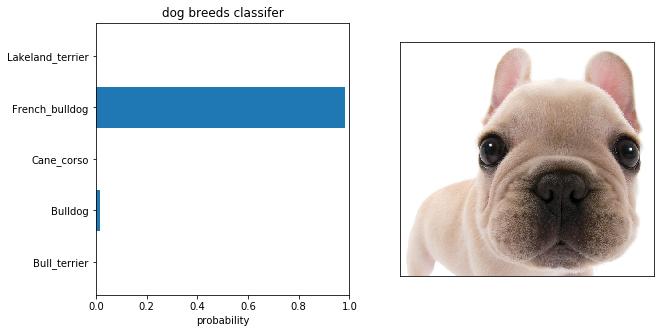

In [233]:
predict_breed('test_imgs/dog.jpg')

No human. No dog.


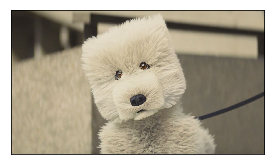

In [234]:
predict_breed('test_imgs/dog1.jpg')

Hello, human!
You look like English_toy_spaniel !


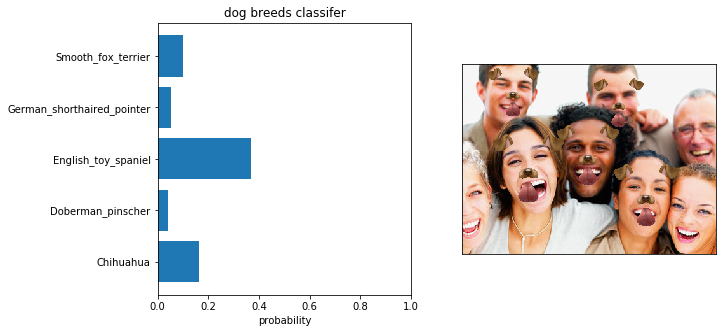

Number of faces detected: 5


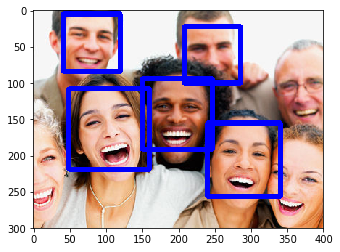

In [235]:
predict_breed('test_imgs/people.jpg')
show_bounding_box_4_detected_face('test_imgs/people.jpg')

Hello, human!
You look like Lowchen & Brussels_griffon mixed breed dog!


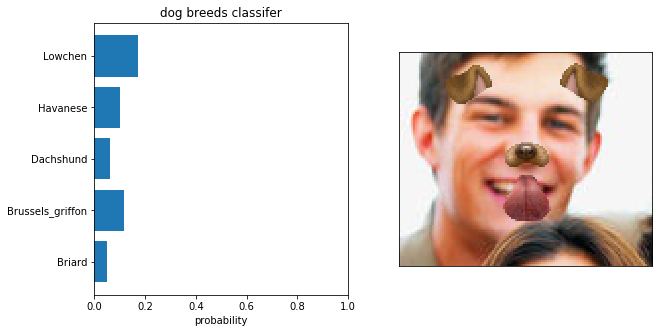

Hello, human!
You look like Curly-coated_retriever !


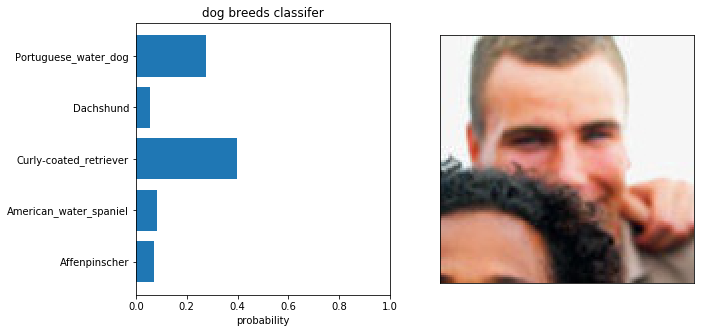

Hello, human!
You look like Doberman_pinscher & Dachshund mixed breed dog!


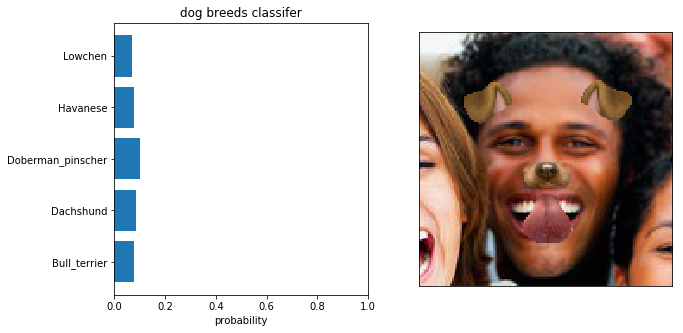

Hello, human!
You look like Afghan_hound & Nova_scotia_duck_tolling_retriever mixed breed dog!


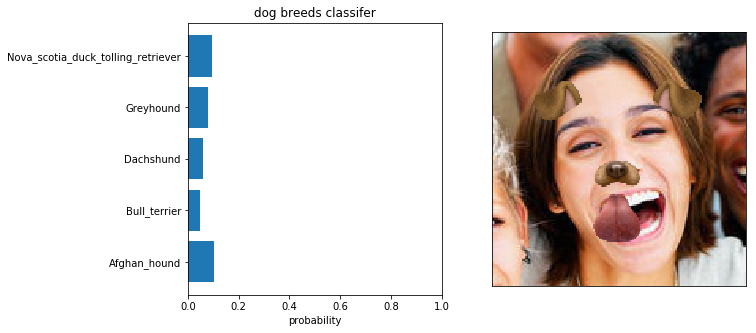

Hello, human!
You look like Doberman_pinscher !


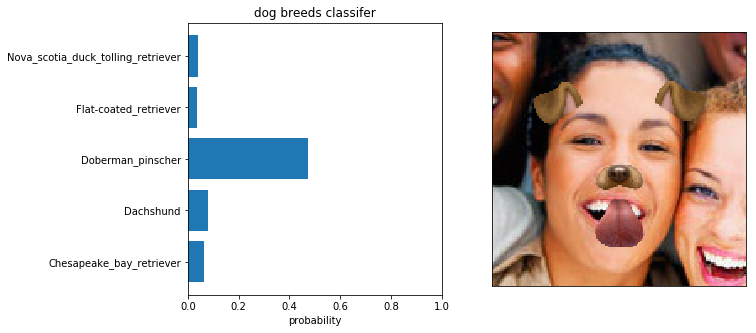

In [238]:
improved_predict_breed('test_imgs/people.jpg')

Hello, human!
You look like Chinese_shar-pei & Chinese_crested mixed breed dog!


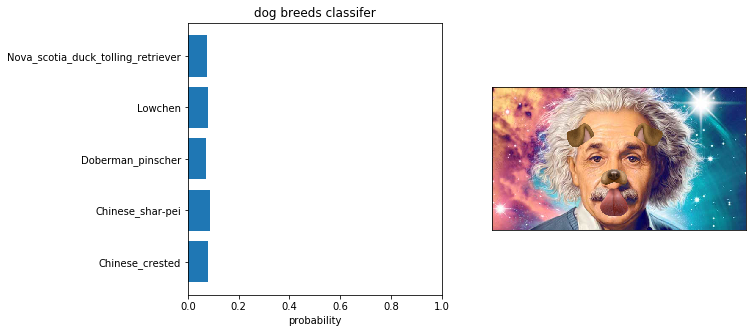

In [239]:
predict_breed('test_imgs/albert_einstein.jpg')

Hello, human!
You look like Smooth_fox_terrier & Chihuahua mixed breed dog!


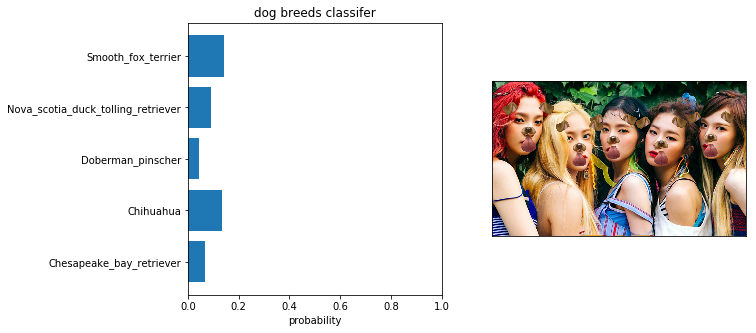

In [240]:
predict_breed('test_imgs/red_velvet.jpg')

Hello, human!
You look like Afghan_hound & Havanese mixed breed dog!


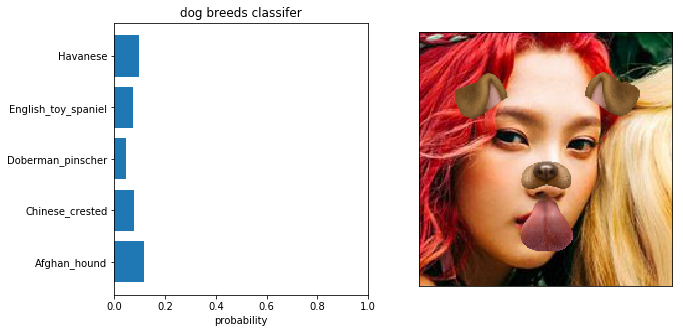

Hello, human!
You look like Smooth_fox_terrier & English_toy_spaniel mixed breed dog!


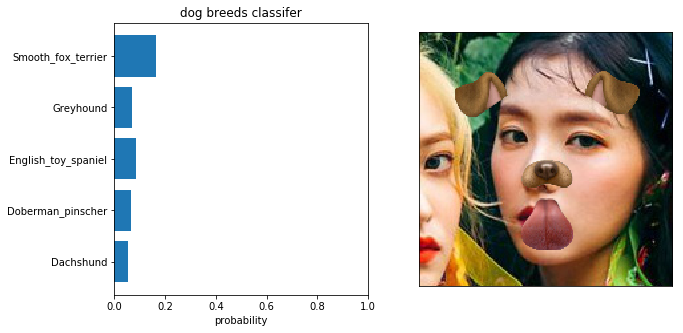

Hello, human!
You look like Dachshund & Havanese mixed breed dog!


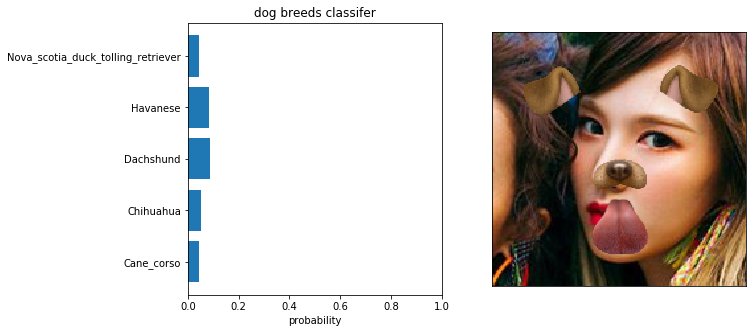

Hello, human!
You look like Lowchen & Havanese mixed breed dog!


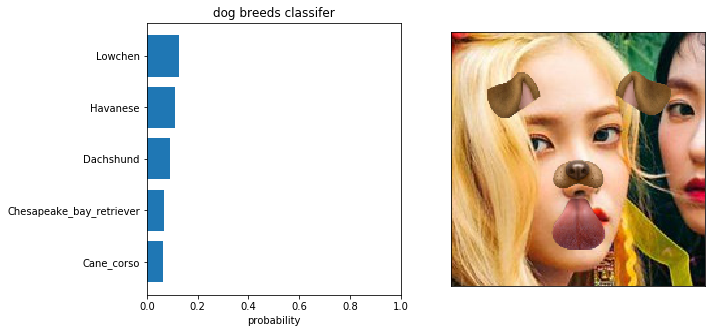

Hello, human!
You look like Chesapeake_bay_retriever & English_toy_spaniel mixed breed dog!


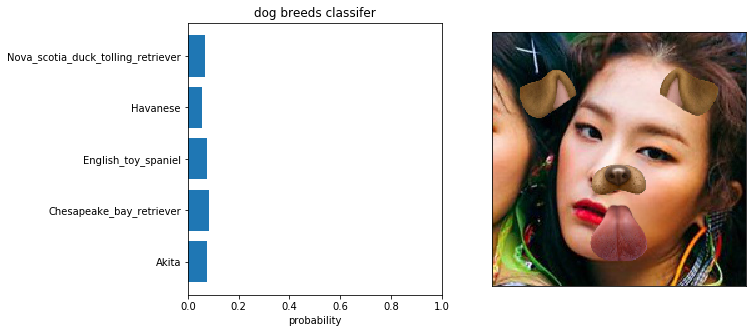

In [241]:
improved_predict_breed('test_imgs/red_velvet.jpg')

Hello, human!
You look like Yorkshire_terrier !


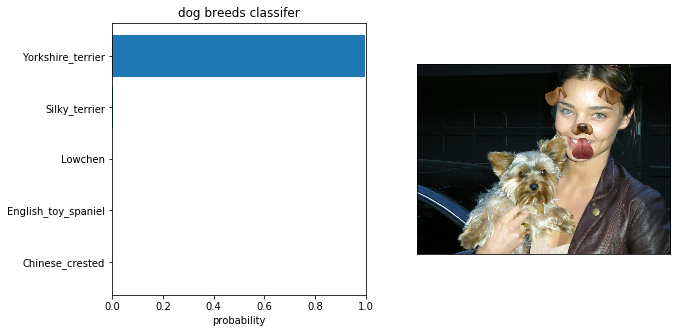

Hello, dog!
You look like Yorkshire_terrier !


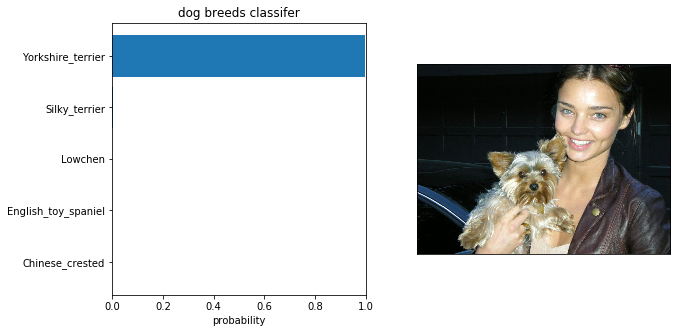

In [242]:
predict_breed('test_imgs/celebrity_dog.jpg')

Hello, dog!
You look like Yorkshire_terrier !


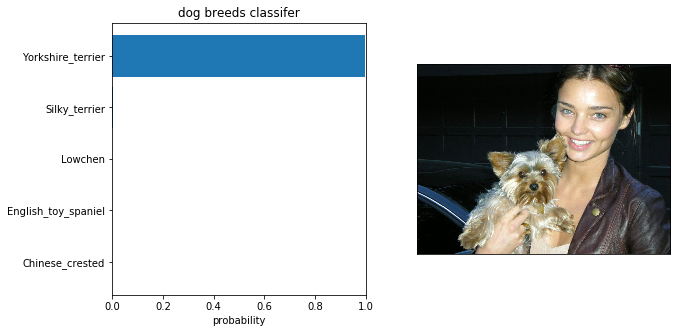

Hello, human!
You look like Norwich_terrier !


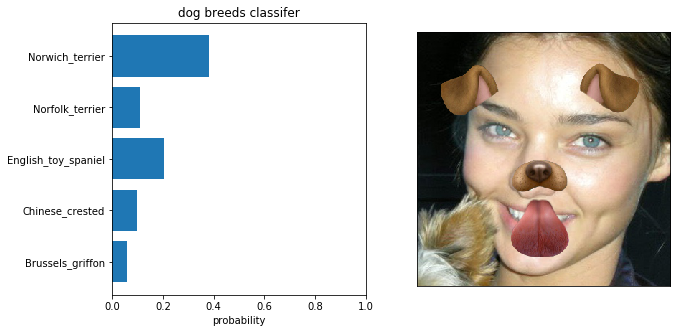

In [243]:
improved_predict_breed('test_imgs/celebrity_dog.jpg')

Hello, human!
You look like Cocker_spaniel & Golden_retriever mixed breed dog!


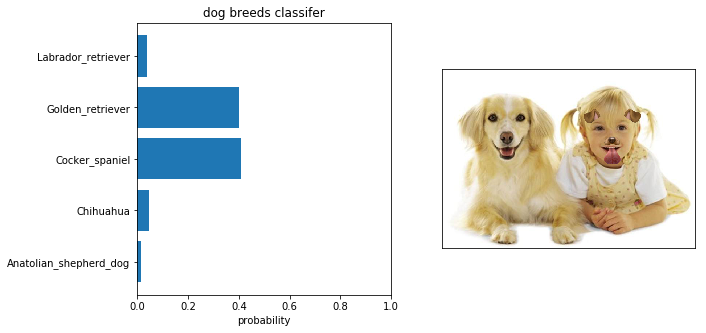

Hello, dog!
You look like Cocker_spaniel & Golden_retriever mixed breed dog!


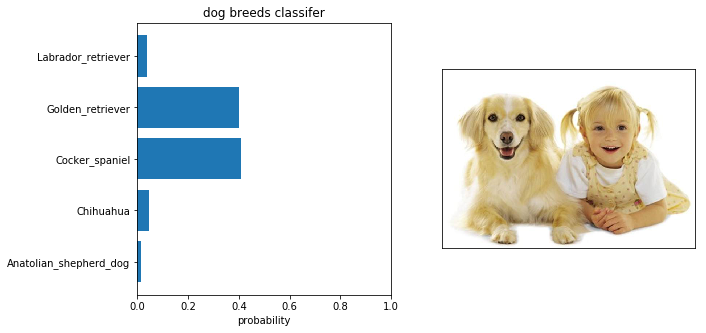

In [244]:
predict_breed('test_imgs/human_n_dog.jpg')

Hello, dog!
You look like Cocker_spaniel & Golden_retriever mixed breed dog!


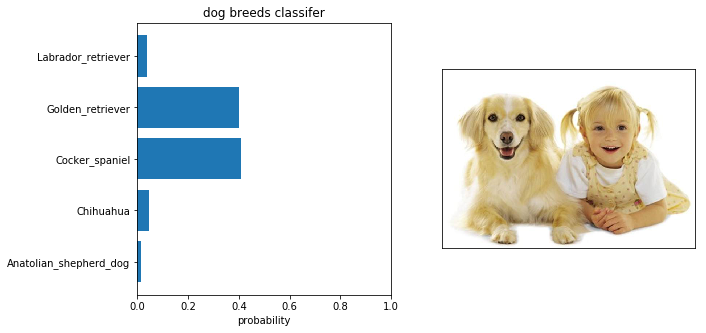

Hello, human!
You look like Smooth_fox_terrier & Chinese_shar-pei mixed breed dog!


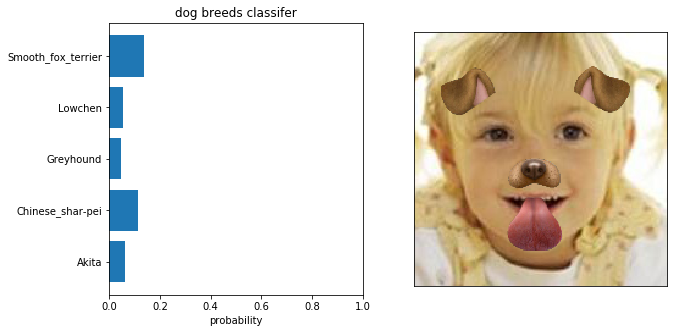

In [245]:
improved_predict_breed('test_imgs/human_n_dog.jpg')

Hello, dog!
You look like Nova_scotia_duck_tolling_retriever & Golden_retriever mixed breed dog!


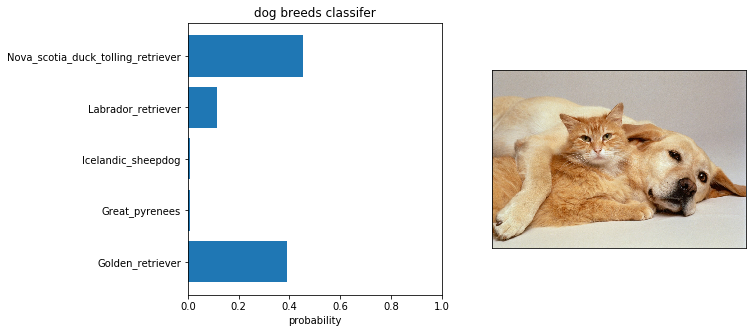

In [246]:
predict_breed('test_imgs/Dog_n_Cat.jpg')

Hello, dog!
You look like Doberman_pinscher !


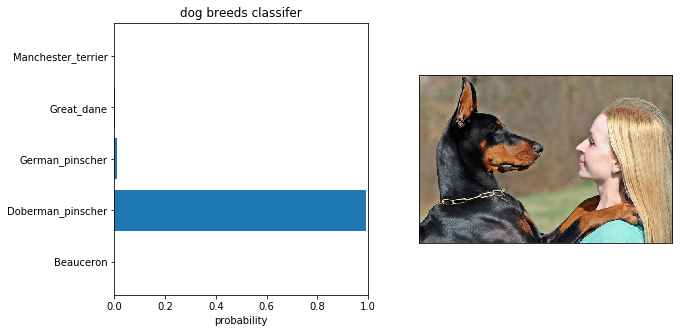

In [247]:
improved_predict_breed('test_imgs/human_n_dog2.jpg')

Hello, dog!
You look like Lhasa_apso !


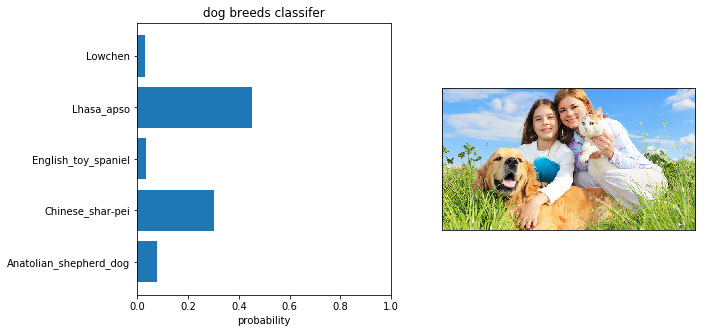

Hello, human!
You look like Nova_scotia_duck_tolling_retriever & Chesapeake_bay_retriever mixed breed dog!


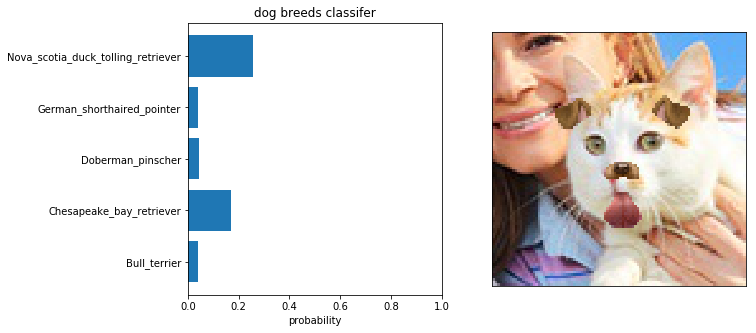

Hello, human!
You look like Chinese_crested & Dachshund mixed breed dog!


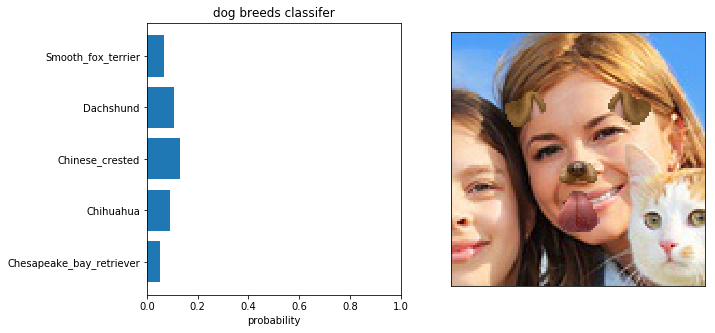

Hello, human!
You look like Icelandic_sheepdog & Doberman_pinscher mixed breed dog!


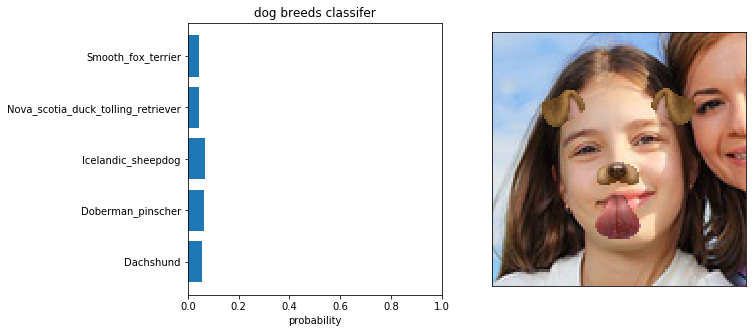

Number of faces detected: 3


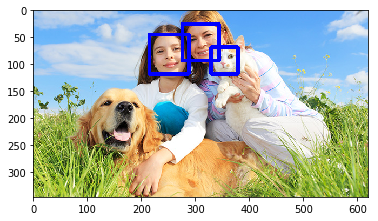

In [248]:
improved_predict_breed('test_imgs/human_n_dog3.jpg')
show_bounding_box_4_detected_face('test_imgs/human_n_dog3.jpg')

Hello, dog!
You look like Nova_scotia_duck_tolling_retriever !


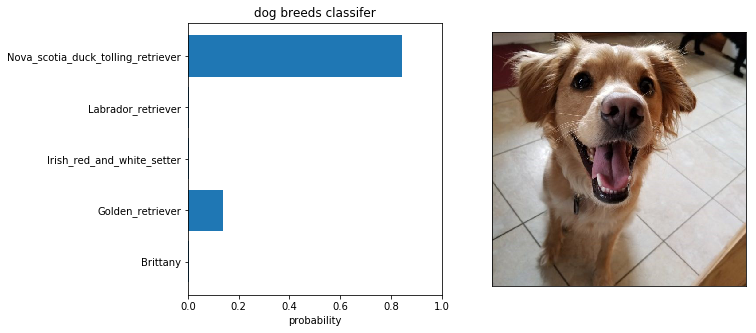

In [249]:
predict_breed('test_imgs/Golden_Cocker_Retriever.jpg')

Hello, dog!
You look like Flat-coated_retriever & Icelandic_sheepdog mixed breed dog!


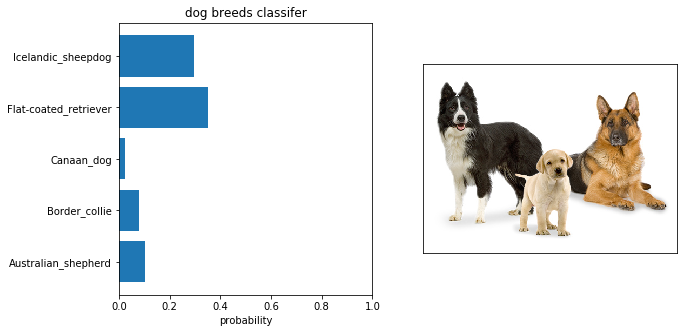

In [250]:
predict_breed('test_imgs/dogs.jpg')

Hello, dog!
You look like Brussels_griffon !


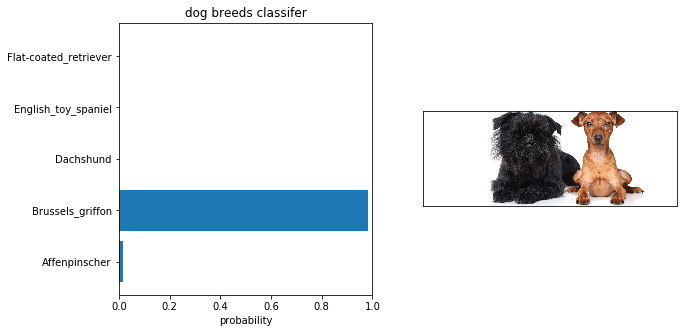

In [251]:
predict_breed('test_imgs/dogs2.jpg')

No human. No dog.


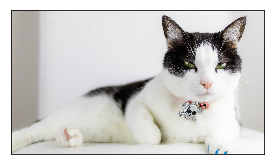

In [252]:
predict_breed('test_imgs/cat.jpg')

No human. No dog.


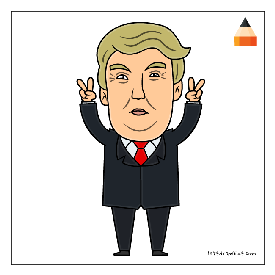

In [253]:
predict_breed('test_imgs/people_cartoon.png')

No human. No dog.


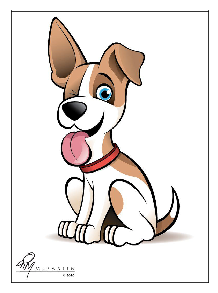

In [254]:
predict_breed('test_imgs/dog_cartoon.jpg')

Hello, dog!
You look like Dachshund & Cocker_spaniel mixed breed dog!


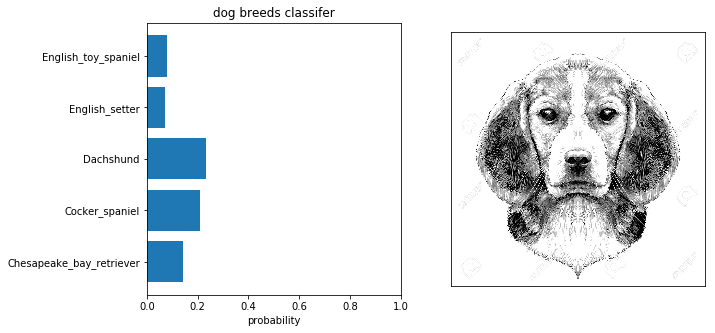

In [255]:
predict_breed('test_imgs/cocker_spaniel_clipart_sketch.jpg')

Hello, dog!
You look like Kuvasz !


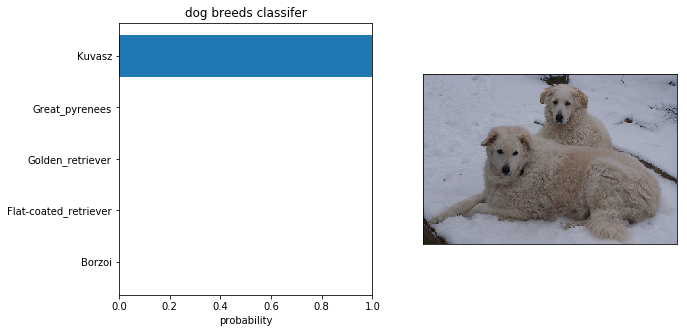

Hello, human!
You look like Kuvasz !


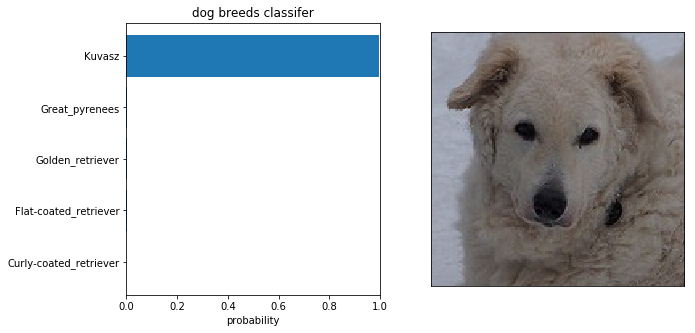

In [88]:
improved_predict_breed(train_files[0])

# Web App 

Please check dog breed web_app folder.

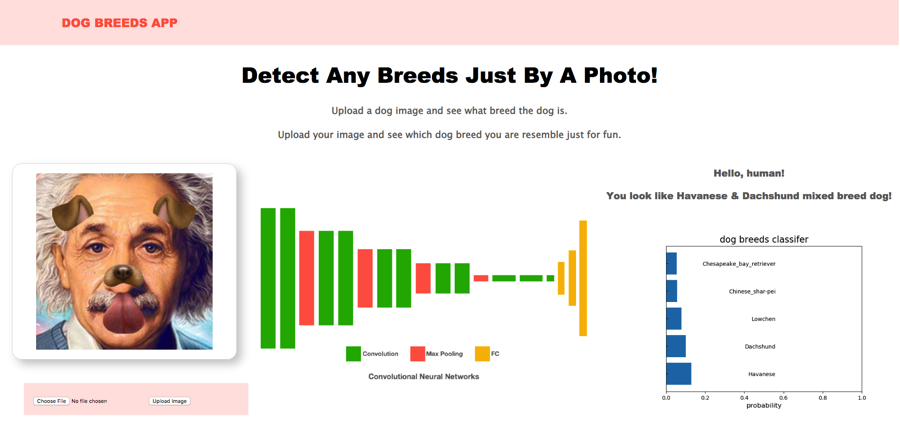

In [4]:
from IPython.display import Image
Image(filename='web_app_snapshot.png') 

# Please download your notebook to submit

In order to submit, please do the following:
1.  Download an HTML version of the notebook to your computer using 'File: Download as...'
2.  Click on the orange Jupyter circle on the top left of the workspace.
3.  Navigate into the dog-project folder to ensure that you are using the provided dog_images, lfw, and bottleneck_features folders; this means that those folders will *not* appear in the dog-project folder.  If they do appear because you downloaded them, delete them.
4.  While in the dog-project folder, upload the HTML version of this notebook you just downloaded.  The upload button is on the top right.
5.  Navigate back to the home folder by clicking on the two dots next to the folder icon, and then open up a terminal under the 'new' tab on the top right
6.  Zip the dog-project folder with the following command in the terminal:
 `zip -r dog-project.zip dog-project`
7.  Download the zip file by clicking on the square next to it and selecting 'download'.  This will be the zip file you turn in on the next node after this workspace!